## DS 4400 Final Project
### Author: Peyton Burns

# Imports

In [1]:
# Project Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from collections import defaultdict

import re

from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD

import warnings

# Dataset and Exploratory Analysis

In [2]:
# Reading in Dataset
language_df = pd.read_csv('language.csv')
language_df.head(5)

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


In [3]:
# Dataset length
print("Dataset Size: ", language_df.shape[0])

Dataset Size:  22000


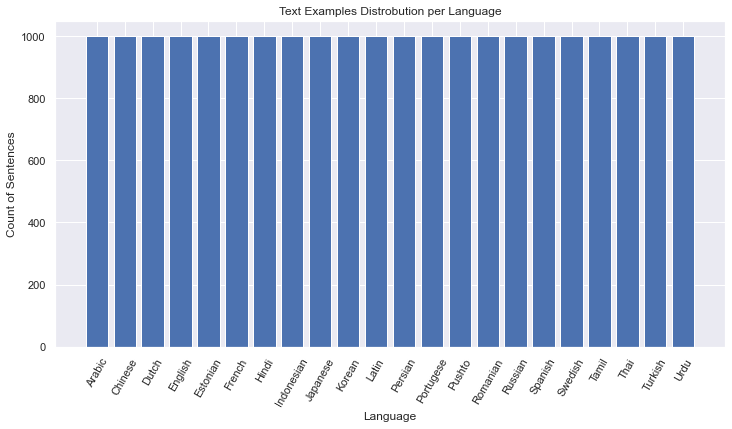

In [4]:
# Dataset distrobution
# Distrobution of text examples per language
count_per_language = language_df.groupby('language').count()
languages = []
counts = []
for language, count in count_per_language.iterrows():
    languages.append(language)
    counts.append(count[0])

sns.set()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.bar(x=languages, height=counts)
plt.xticks(rotation=60)
plt.title("Text Examples Distrobution per Language")
plt.ylabel("Count of Sentences")
plt.xlabel("Language")
plt.show()

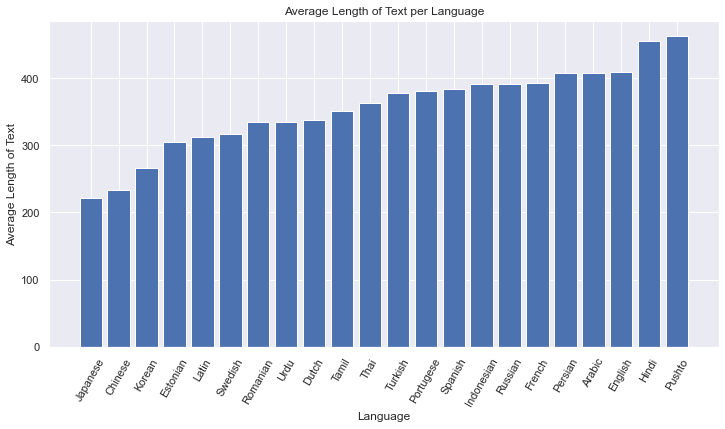

In [5]:
# Average character length of sentences by language
text_length = defaultdict(lambda: [])
for row in language_df.iterrows():
    lang = row[1]['language']
    length = len(row[1]['Text'])
    text_length[lang].append(length)
    
character_avgs = {}
for language in text_length.keys():
    character_avgs[language] = sum(text_length[language]) / len(text_length[language])

sorted_char_avgs = {key: val for key, val in sorted(character_avgs.items(), key=lambda item: item[1])}
languages, avgs = zip(*sorted_char_avgs.items())

sns.set()
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.bar(x=languages, height=avgs)
plt.xticks(rotation=60)
plt.title("Average Length of Text per Language")
plt.ylabel("Average Length of Text")
plt.xlabel("Language")
plt.show()

In [6]:
# Some data abnormalities
# 8, 15, 41, 45, 82, 92
anomalies_df = language_df.loc[language_df.index.isin([8, 15, 41, 45, 82, 92])]
anomalies_df

,Text,language
8,برقی بار electric charge تمام زیرجوہری ذرات کی...,Urdu
15,การฟาดฟันของบรรดาสาวงามในกองประกวด miss beauty...,Thai
41,زلاتان ابراھیموویچ zlatan ibrahimović سویڈش تل...,Urdu
45,教会旋法はまず終止音（finalis）によってつに分類される。そしてそれぞれが音域（ambi...,Japanese
82,زیردریایی یو- به انگلیسی german submarine u- ی...,Persian
92,chinchilla longhair adalah kucing yang berasal...,Indonesian


# Engineered Variable Creation

In [7]:
def create_ngrams(data, languages, n=1, top_n=200):
    n_gram_features = {}
    all_n_gram_features = set()
    for lang in languages: 
        # Getting text per language and fitting an ngram vectorizer at character level
        corpus = data[data['language']==lang]['Text']
        # Using char analyzer to create ngrams at char level
        vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), max_features=top_n)
        _ = vectorizer.fit_transform(corpus)
    
        # Extract top_n char n_grams
        feats = vectorizer.get_feature_names()
        n_gram_features[lang] = feats
        all_n_gram_features.update(feats)

    return n_gram_features, all_n_gram_features

def create_ngram_vocabulary(all_n_gram_features, n=1, top_n=200):
    vocab = {}
    counter = 0
    for feat in all_n_gram_features:
        vocab[feat] = counter
        counter += 1
        
    return vocab

def create_feature_df(language_df, languages, n_gram_size, top_n):
    # Creating ngrams from text samples in language_df
    n_gram_features, all_n_gram_features = create_ngrams(language_df, languages, n=n_gram_size, top_n=top_n)
    
    # Creating a full vocabulary of all n_gram features
    n_gram_vocab = create_ngram_vocabulary(all_n_gram_features, n=n_gram_size, top_n=top_n)
    
    # Vecotizing ngrams into usable features
    X = language_df['Text']
    vectorizer = CountVectorizer(analyzer='char', 
                             ngram_range=(n_gram_size, n_gram_size), vocabulary=n_gram_vocab)
    X = vectorizer.fit_transform(X)
    feats = vectorizer.get_feature_names()
    
    features_df = pd.DataFrame(X.toarray(), columns=feats)
    features_df['language'] = language_df['language']
    
    return features_df, vectorizer

In [8]:
# Creating character level features for unigrams through trigrams from data
unigrams_df, unigram_vectorizer = create_feature_df(language_df, languages, 1, 200)

bigrams_df, unigram_vectorizer = create_feature_df(language_df, languages, 2, 200)

trigrams_df, unigram_vectorizer = create_feature_df(language_df, languages, 3, 200)

In [9]:
# Unigram features
unigrams_df.head(5)

,ב,"""",恵,ﮑ,و,스,ؤ,ē,т,ք,...,ज,झ,$,電,懨,إ,د,எ,फ,language
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Estonian
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Swedish
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Thai
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Tamil
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dutch


In [10]:
# Bigram features
bigrams_df.head(5)

,بل,ாள,mp,第二,여,од,이었,”。,ہر,рн,...,िन,ما,மி,터,이,ு,जो,지,ün,language
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Estonian
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Swedish
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Thai
3,0,0,0,0,0,0,0,0,0,0,...,0,0,5,0,0,3,0,0,0,Tamil
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dutch


In [11]:
# Trigram features
trigrams_df.head(5)

,ी म,ओं,pou,之一。,ของ,ے ا,โรง,よって,का,ा ग,...,r t,پار,之后，,의해,pl,ید,द्व,रण,naa,language
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Estonian
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Swedish
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Thai
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Tamil
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Dutch


In [12]:
# Creating simple count vectorizer for features
cv = CountVectorizer()
X_cv = cv.fit_transform(language_df['Text'])

# Model Creation

In [13]:
def report_metrics(gold_labels, predicted_labels, name, clf):
    # Reporting metrics & confusion matrix
    acc = round(accuracy_score(gold_labels, predicted_labels), 4)
    err = round(1 - acc, 4)
    pre = round(precision_score(gold_labels, predicted_labels, average='macro'), 4)
    rec = round(recall_score(gold_labels, predicted_labels, average='macro'), 4)
    f1 = round(f1_score(gold_labels, predicted_labels, average='macro'), 4)

    print("Accuracy: ", acc)
    print("Error: ", err)
    print("Precision: ", pre)
    print("Recall: ", rec)
    print("F1-Score: ", f1)

    cf_matrix = confusion_matrix(gold_labels, predicted_labels, labels=clf.classes_)
    rcParams['figure.figsize'] = 16,12
    sns.heatmap(cf_matrix, annot=True, cmap="Greens", xticklabels=nb_clf.classes_, yticklabels=clf.classes_, fmt='g')
    plt.title(name)
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

### Naive Bayes
Naive Bayes trained with Bag-Of-Words Features

In [14]:
# Splitting data for training & testing
y = language_df['language']
X_train, X_test, y_train, y_test = train_test_split(X_cv, y, test_size=0.2, random_state=18)

# Creating NB model
nb_clf = MultinomialNB()

# Training with count vectors feature
nb_clf.fit(X_train, y_train)

MultinomialNB()

Accuracy:  0.957
Error:  0.043
Precision:  0.9643
Recall:  0.9559
F1-Score:  0.9564


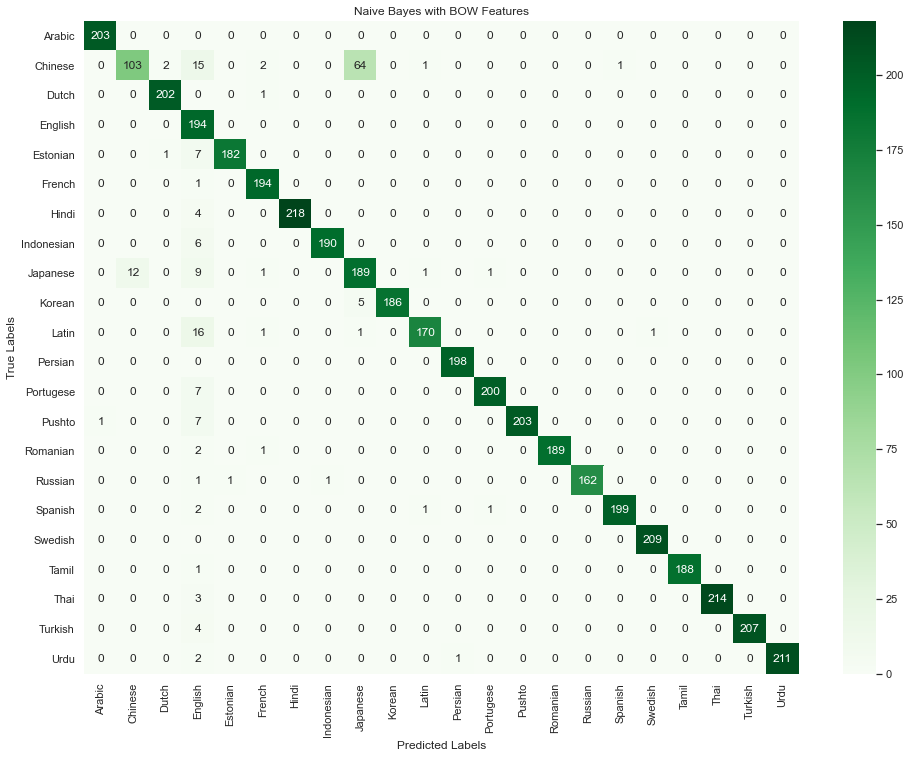

In [15]:
# Making predictions
predicted_labels = nb_clf.predict(X_test)

# Reporting metrics & confusion matrix
report_metrics(y_test, predicted_labels, "Naive Bayes with BOW Features", nb_clf)

### KNN Model
KNN Model with character level unigram features

In [16]:
# Splitting data for training & testing
y = language_df['language']
X_train, X_test, y_train, y_test = train_test_split(unigrams_df.drop('language', axis=1), y, test_size=0.2, random_state=18)

In [17]:
# Training KNN model with Unigrams
knn_unigram_model = KNeighborsClassifier(20)

knn_unigram_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

Accuracy:  0.9436
Error:  0.0564
Precision:  0.9453
Recall:  0.9433
F1-Score:  0.9438


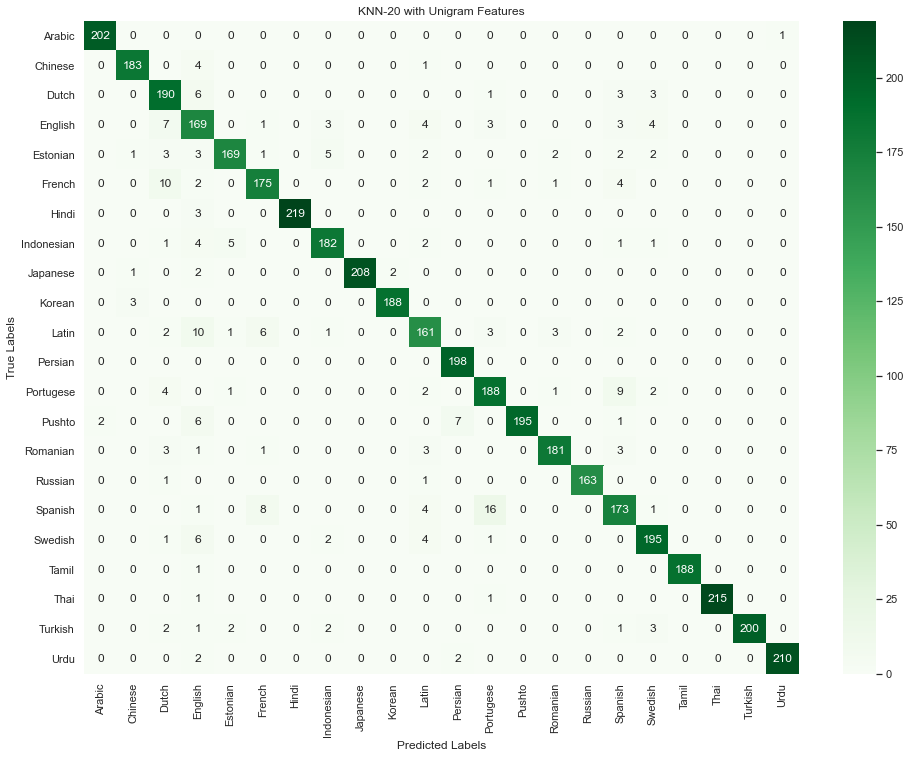

In [18]:
# Making predictions
predicted_labels = knn_unigram_model.predict(X_test)

# Reporting metrics & confusion matrix
report_metrics(y_test, predicted_labels, "KNN-20 with Unigram Features", knn_unigram_model)

### KNN Model
KNN Model with character level bigram features

In [19]:
# Splitting data for training & testing
y = language_df['language']
X_train, X_test, y_train, y_test = train_test_split(bigrams_df.drop('language', axis=1), y, test_size=0.2, random_state=18)

In [20]:
# Training KNN model with Bigrams
knn_bigram_model = KNeighborsClassifier(20)

knn_bigram_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

Accuracy:  0.942
Error:  0.058
Precision:  0.9598
Recall:  0.9429
F1-Score:  0.9461


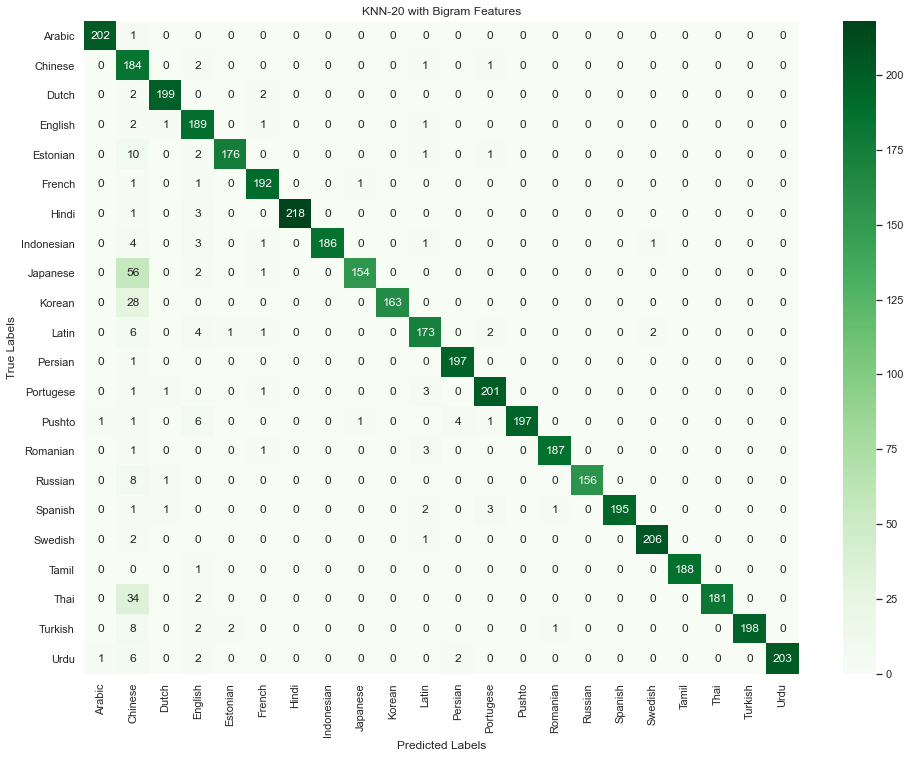

In [21]:
# Making predictions
predicted_labels = knn_bigram_model.predict(X_test)

# Reporting metrics & confusion matrix
report_metrics(y_test, predicted_labels, "KNN-20 with Bigram Features", knn_bigram_model)

### KNN Model
KNN Model with character level trigram features

In [22]:
# Splitting data for training & testing
y = language_df['language']
X_train, X_test, y_train, y_test = train_test_split(trigrams_df.drop('language', axis=1), y, test_size=0.2, random_state=18)

In [23]:
# Training KNN model with Trigrams
knn_trigram_model = KNeighborsClassifier(20)

knn_trigram_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

Accuracy:  0.7416
Error:  0.2584
Precision:  0.945
Recall:  0.7407
F1-Score:  0.8027


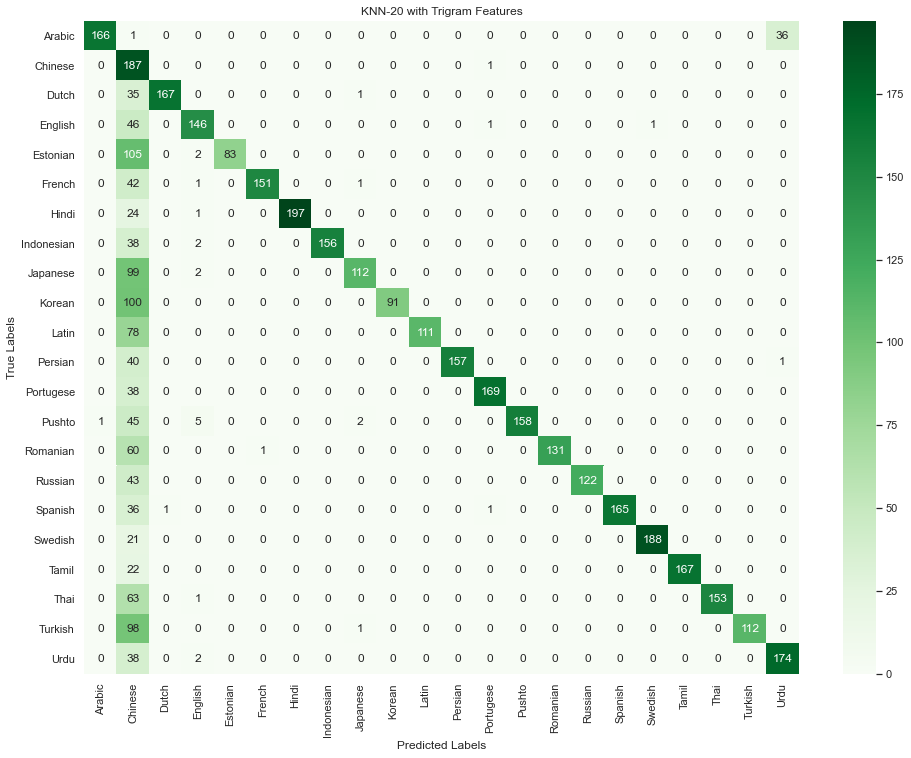

In [24]:
# Making predictions
predicted_labels = knn_trigram_model.predict(X_test)

# Reporting metrics & confusion matrix
report_metrics(y_test, predicted_labels, "KNN-20 with Trigram Features", knn_trigram_model)

### Random Forest Ensemble
Random Forest Ensemble with character level trigram features

In [25]:
# Splitting data for training & testing
y = language_df['language']
X_train, X_test, y_train, y_test = train_test_split(trigrams_df.drop('language', axis=1), y, test_size=0.2, random_state=18)

In [26]:
# Training Random Forest model with Bigrams
rf_model = RandomForestClassifier(max_depth=3, random_state=0)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=0)

C:\Users\pburn\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.8395
Error:  0.1605
Precision:  0.8566
Recall:  0.8397
F1-Score:  0.8303


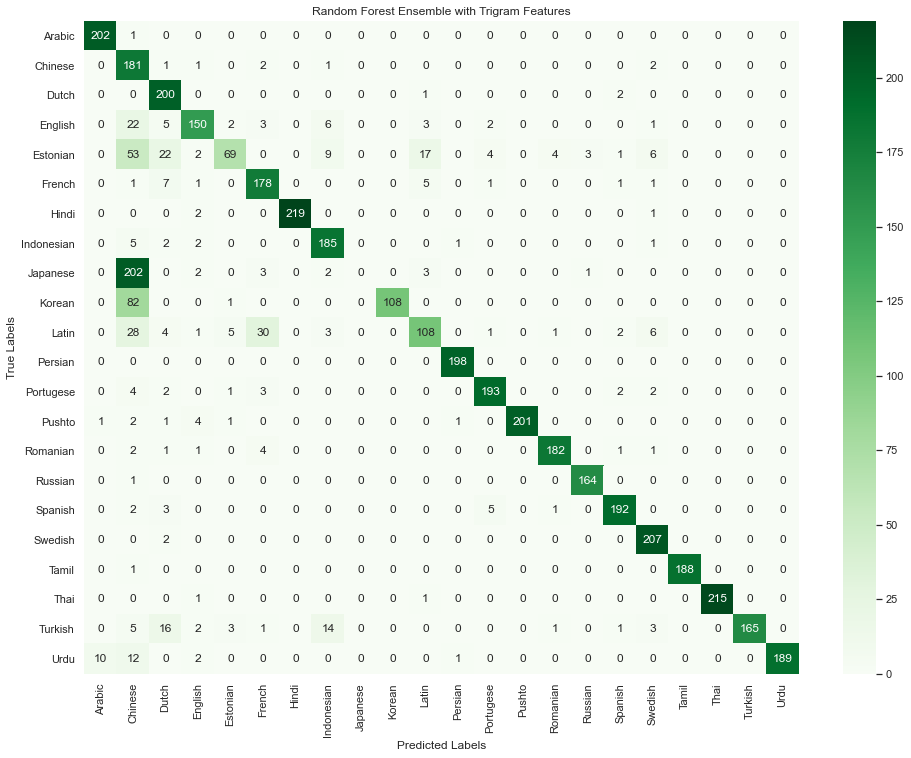

In [27]:
# Making predictions
predicted_labels = rf_model.predict(X_test)

# Reporting metrics & confusion matrix
report_metrics(y_test, predicted_labels, "Random Forest Ensemble with Trigram Features", rf_model)

### Feed Forward Neural Network
Feed Forward Neural Network trained using character level trigram features

In [28]:
# Splitting data for training & testing
# Setting up labels for NN
encoder = LabelEncoder()
encoder.fit(languages)

y_encoded = encoder.transform(language_df['language'])
y_categorical = to_categorical(y_encoded)
y_categorical = pd.DataFrame(y_categorical, columns=range(0, 22))
y_categorical['language'] = language_df['language']

X_train, X_test, y_train, y_test = train_test_split(trigrams_df.drop('language', axis=1), y_categorical, 
                                                    test_size=0.2, random_state=18)

In [29]:
# Creating Feed Forward Network
nn_model = Sequential()
nn_model.add(Input(X_train.shape[1]))
nn_model.add(Dense(600, activation='relu'))
nn_model.add(Dense(600, activation='relu'))
nn_model.add(Dense(400, activation='relu'))
nn_model.add(Dense(y_train.shape[1] - 1, activation='softmax'))
nn_model.compile(loss=CategoricalCrossentropy(), optimizer=SGD(learning_rate=.1), metrics=['accuracy'])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               1787400   
_________________________________________________________________
dense_1 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_2 (Dense)              (None, 400)               240400    
_________________________________________________________________
dense_3 (Dense)              (None, 22)                8822      
Total params: 2,397,222
Trainable params: 2,397,222
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Fitting Neural Network
nn_model.fit(X_train, y_train.drop('language', axis=1), epochs=40, batch_size=100, verbose=1)

Epoch 1/40
176/176 [==============================] - 2s 12ms/step - loss: 0.6174 - accuracy: 0.9020
Epoch 2/40
176/176 [==============================] - 3s 14ms/step - loss: 0.1355 - accuracy: 0.9755
Epoch 3/40
176/176 [==============================] - 2s 13ms/step - loss: 0.0837 - accuracy: 0.9820
Epoch 4/40
176/176 [==============================] - 2s 14ms/step - loss: 0.0557 - accuracy: 0.9878
Epoch 5/40
176/176 [==============================] - 2s 12ms/step - loss: 0.0425 - accuracy: 0.9902
Epoch 6/40
176/176 [==============================] - 2s 12ms/step - loss: 0.0320 - accuracy: 0.9933
Epoch 7/40
176/176 [==============================] - 2s 13ms/step - loss: 0.0230 - accuracy: 0.9956
Epoch 8/40
176/176 [==============================] - 2s 13ms/step - loss: 0.0178 - accuracy: 0.9972 0s - loss: 0.0176 - ac
Epoch 9/40
176/176 [==============================] - 2s 12ms/step - loss: 0.0145 - accuracy: 0.9978
Epoch 10/40
176/176 [==============================] - 2s 13ms/step 

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy:  0.9827
Error:  0.0173
Precision:  0.9827
Recall:  0.9826
F1-Score:  0.9825


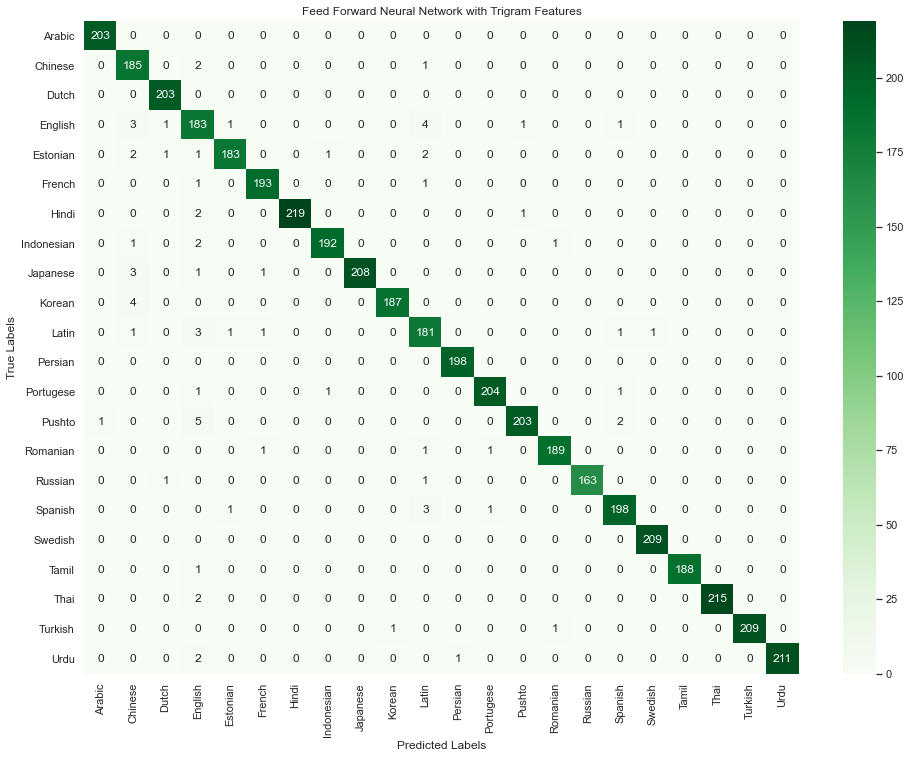

In [31]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Making predictions
predicted_labels = nn_model.predict_classes(X_test)
predicted_labels = encoder.inverse_transform(predicted_labels)

# Reporting metrics & confusion matrix
report_metrics(y_test['language'], predicted_labels, "Feed Forward Neural Network with Trigram Features", rf_model)